In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import bitfinex
from datetime import datetime
import time
import math


# ML methods
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error


import math
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from keras.callbacks import LearningRateScheduler
from keras.metrics import RootMeanSquaredError
from sklearn.linear_model import LinearRegression


In [8]:
api_v1 = bitfinex.bitfinex_v1.api_v1()
pairs = api_v1.symbols()

No keys, only access to public API functions


In [46]:
def fetch_data(start=1640991600000, stop=1651356000000, symbol='btcusd', interval='1D', step=86400000):
    # Create api instance
    api_v2 = bitfinex.bitfinex_v2.api_v2()

    # Defining intervals in ms
    intervals_dict = {"1m": 60000, "5m": 300000, "15m": 900000, "30m": 1800000, "1h": 3600000, "3h": 10800000, "6h": 21600000, "12h": 43200000, "1D": 86400000, "7D": 604800000, "14D": 1209600000, "1M": 2628000000}
    step = intervals_dict[interval] * 1000

    
    data = []
    names = ['time', 'open', 'close', 'high', 'low', 'volume']

    if stop > time.time() * 1000: # stop value can't be higher than datetime.now()
        stop = datetime.now()
        stop = time.mktime(stop.timetuple()) * 1000
    if stop - start > step: # if data requested > 1000 * interval
        while start < stop:
            if start + step > stop: # if start + 1000 * interval > stop ==> stop = now
                end = datetime.now()
                end = time.mktime(end.timetuple()) * 1000
            else:
                end = start + step
            #print(datetime.fromtimestamp(start / 1000), datetime.fromtimestamp(end / 1000))
            res = api_v2.candles(symbol=symbol, interval=interval, start=start, end=end)
            data.extend(res)
            start += step
            time.sleep(1)
    else:
        res = api_v2.candles(symbol=symbol, interval=interval, start=start, end=stop)
        data.extend(res)
    #print(data)

    # Modify data to send back a clean DataFrame
    df = pd.DataFrame(data, columns=names)
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df = df.sort_values(by='time')
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    df.rename(columns={'time':'date'}, inplace=True)
    return df

In [47]:
pair = 'btcusd'
interval = '1D'

t_start = datetime(2019, 1, 1, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

t_stop = datetime(2023, 5, 3, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

In [48]:
df = fetch_data(start=t_start, stop=t_stop, symbol=pair, interval=interval)
df

No keys, only access to public API functions


,date,open,close,high,low,volume
0,2019-01-01,3832.628624,3963.1,3987.000000,3788.1,13848.346752
1,2019-01-02,3963.000000,4048.8,4083.470676,3917.9,19437.727989
2,2019-01-03,4049.000000,3924.3,4056.644331,3875.1,10748.083712
3,2019-01-04,3923.200000,3954.9,3986.000000,3850.1,13228.660465
4,2019-01-05,3954.900000,3911.9,4014.900000,3901.0,14873.962225
...,...,...,...,...,...,...
1247,2022-06-01,31798.258947,29833.0,31974.161427,29346.0,4840.929434
1248,2022-06-02,29843.000000,30478.0,30719.000000,29610.0,5926.415499
1249,2022-06-03,30473.755590,29730.0,30708.178739,29300.0,3038.214263
1250,2022-06-04,29719.000000,29874.0,30028.000000,29498.0,1500.541359


In [49]:
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

In [50]:
def SplitData(Data, Date, lstm=0, X_scaler=X_scaler, y_scaler=y_scaler):
  index = Data.index[Data['date'] == Date][0]
  X = Data.drop(columns=['date', 'close', 'volume'], axis=1).to_numpy()
  y = Data['close'].to_numpy()

  if lstm:
    X = X_scaler.fit_transform(np.array(X))
    y = y_scaler.fit_transform(np.array(y).reshape(-1,1))

    X_train = X[:index]
    y_train = y[:index]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    X_test = X[index:]
    y_test = y[index:]
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  else:
    X_train = X[:index]
    y_train = y[:index]
    X_test = X[index:]
    y_test = y[index:]

  return X_train, y_train, X_test, y_test

# Linear Regression

In [51]:
date = '2022-02-01'
X_train, y_train, X_test, y_test = SplitData(df, date)

In [52]:
df

,date,open,close,high,low,volume
0,2019-01-01,3832.628624,3963.1,3987.000000,3788.1,13848.346752
1,2019-01-02,3963.000000,4048.8,4083.470676,3917.9,19437.727989
2,2019-01-03,4049.000000,3924.3,4056.644331,3875.1,10748.083712
3,2019-01-04,3923.200000,3954.9,3986.000000,3850.1,13228.660465
4,2019-01-05,3954.900000,3911.9,4014.900000,3901.0,14873.962225
...,...,...,...,...,...,...
1247,2022-06-01,31798.258947,29833.0,31974.161427,29346.0,4840.929434
1248,2022-06-02,29843.000000,30478.0,30719.000000,29610.0,5926.415499
1249,2022-06-03,30473.755590,29730.0,30708.178739,29300.0,3038.214263
1250,2022-06-04,29719.000000,29874.0,30028.000000,29498.0,1500.541359


## Test

In [53]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

LinearRegression()

In [54]:
linear_regression_train_predict=linear_regression_model.predict(X_train)
linear_regression_validation_predict=linear_regression_model.predict(X_test)

print("Train data prediction:", linear_regression_train_predict.shape)
print("Validation data prediction:", linear_regression_validation_predict.shape)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, linear_regression_validation_predict)))

Train data prediction: (1127,)
Validation data prediction: (125,)
Mean Absolute Error - MAE : 394.9298056605951


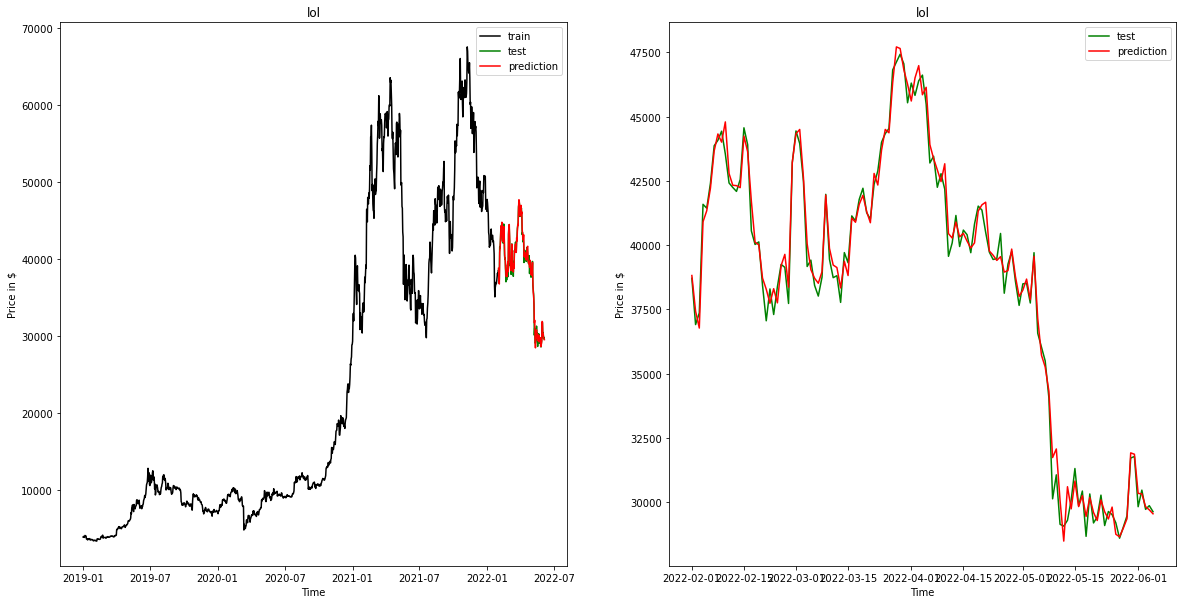

In [55]:
train_size = X_train.shape[0]
f,axs = plt.subplots(1,2,figsize=(20,10))

axs[0].set_title("lol")
axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[0].plot(df['date'][train_size:], linear_regression_validation_predict, color='red')
axs[0].legend(['train', 'test', 'prediction'])

axs[1].set_title("lol")
axs[1].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[1].plot(df['date'][train_size:], linear_regression_validation_predict, color='red')
axs[1].legend(['test', 'prediction'])

for ax in axs.flat:
    ax.set(xlabel="Time", ylabel="Price in $")

## Tune

In [86]:
from sklearn.model_selection import GridSearchCV


lr_gs_model = LinearRegression()

# parameters that we will try to tune
params_lr_gs = {
    'n_jobs': range(1, 1000),
}

param_search = GridSearchCV( estimator=lr_gs_model, param_grid=params_lr_gs,
                verbose=1)
                
param_search.fit(X_train, y_train)

best_score = param_search.best_score_
best_params = param_search.best_params_

print(f'Best accuracy: {best_score} was obtained with parameters: {best_params}')

Fitting 5 folds for each of 999 candidates, totalling 4995 fits
Best accuracy: 0.9855291598778531 was obtained with parameters: {'n_jobs': 1}


In [87]:
lr_final_model = LinearRegression(**best_params)
lr_final_model.fit(X_train, y_train)

LinearRegression(n_jobs=1)

In [88]:
lr_final_train_predict=lr_final_model.predict(X_train)
lr_final_validation_predict=lr_final_model.predict(X_test)

print("Train data prediction:", lr_final_train_predict.shape)
print("Validation data prediction:", lr_final_validation_predict.shape)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, lr_final_validation_predict)))

Train data prediction: (509,)
Validation data prediction: (124,)
Mean Absolute Error - MAE : 3.231280766910586


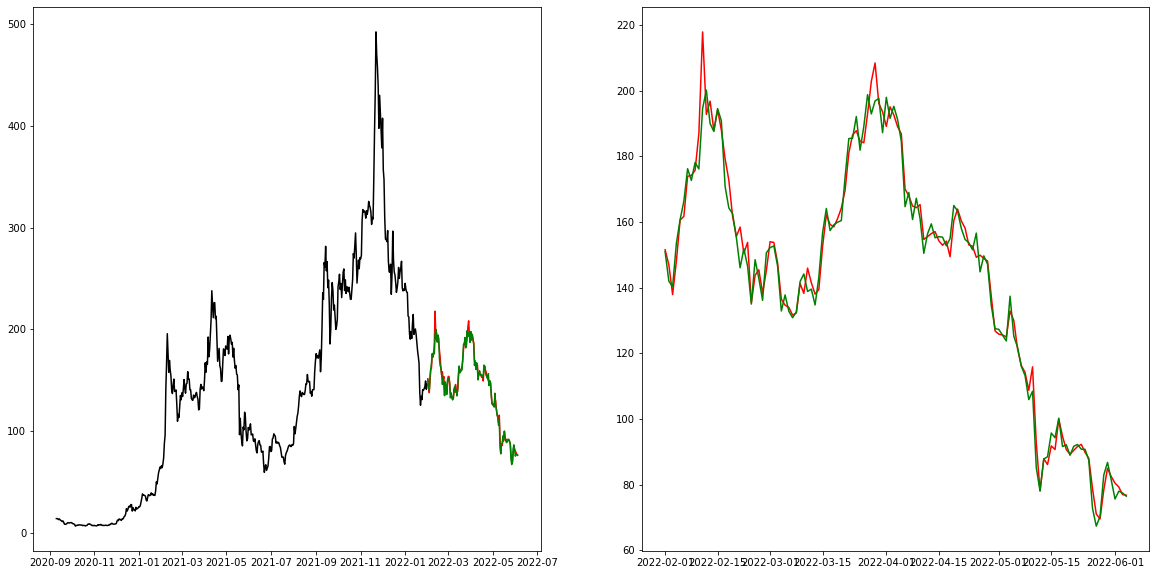

In [89]:
train_size = X_train.shape[0]
f,axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][train_size:], lr_final_validation_predict, color='red')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[1].plot(df['date'][train_size:], lr_final_validation_predict, color='red')
axs[1].plot(df['date'][train_size:], df['close'][train_size:], color='green')

In [90]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,lr_final_train_predict)))
print("Train data MSE: ", mean_squared_error(y_train,lr_final_train_predict))
print("Train data MAE: ", mean_absolute_error(y_train,lr_final_train_predict))
print("Train data explained variance regression score:", explained_variance_score(y_train, lr_final_train_predict))
print("Train data R2 score:", r2_score(y_train, lr_final_train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,lr_final_validation_predict)))
print("Test data MSE: ", mean_squared_error(y_test,lr_final_validation_predict))
print("Test data MAE: ", mean_absolute_error(y_test,lr_final_validation_predict))
print("Test data explained variance regression score:", explained_variance_score(y_test, lr_final_validation_predict))
print("Test data R2 score:", r2_score(y_test, lr_final_validation_predict))

Train data RMSE:  5.715776456560772
Train data MSE:  32.67010050137442
Train data MAE:  3.260388766323926
Train data explained variance regression score: 0.9968521640030937
Train data R2 score: 0.9968521640030937
-------------------------------------------------------------------------------------
Test data RMSE:  4.547488007239977
Test data MSE:  20.679647175991416
Test data MAE:  3.231280766910586
Test data explained variance regression score: 0.9841932047655185
Test data R2 score: 0.9838478234908941


# LSTM

In [56]:
date = '2022-02-01'
X_train, y_train, X_test, y_test = SplitData(df, date, lstm=1)

In [57]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1127, 3, 1), (1127, 1), (125, 3, 1), (125, 1))

## Test

### Working

In [58]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [59]:
np.random.seed(0)
lstm_neurons = 100
epochs = 50
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [60]:
lstm_model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
 activation_4 (Activation)   (None, 1)                 0         
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [61]:
hist = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False)

Epoch 1/50
36/36 [==============================] - 8s 55ms/step - loss: 0.0318 - val_loss: 0.0036
Epoch 2/50
36/36 [==============================] - 0s 11ms/step - loss: 0.0283 - val_loss: 3.1595e-04
Epoch 3/50
36/36 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 4/50
36/36 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 5.8362e-04
Epoch 5/50
36/36 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 2.3622e-04
Epoch 6/50
36/36 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 2.6621e-04
Epoch 7/50
36/36 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 3.0476e-04
Epoch 8/50
36/36 [==============================] - 0s 11ms/step - loss: 9.2576e-04 - val_loss: 3.1245e-04
Epoch 9/50
36/36 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 2.3735e-04
Epoch 10/50
36/36 [==============================] - 0s 12ms/step - loss: 0.0

In [62]:
# make predictions
train_prediction = lstm_model.predict(X_train)
test_prediction = lstm_model.predict(X_test)

# invert predictions

# create empty table with 4 fields
train_prediction_dataset_like, test_prediction_dataset_like = np.zeros(shape=(len(train_prediction), X_train.shape[1])), np.zeros(shape=(len(test_prediction), X_test.shape[1]))
# put the predicted values in the right field
train_prediction_dataset_like[:,0], test_prediction_dataset_like[:,0] = train_prediction[:,0], test_prediction[:,0]
# inverse transform and then select the right field
train_prediction, test_prediction = X_scaler.inverse_transform(train_prediction_dataset_like)[:,0], X_scaler.inverse_transform(test_prediction_dataset_like)[:,0]
train_prediction, test_prediction = train_prediction.reshape(-1,1), test_prediction.reshape(-1,1)

y_train = y_scaler.inverse_transform(y_train)
y_test = y_scaler.inverse_transform(y_test)

In [63]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_prediction)))
print("Train data MSE: ", mean_squared_error(y_train,train_prediction))
print("Train data MAE: ", mean_absolute_error(y_train,train_prediction))
print("Train data explained variance regression score:", explained_variance_score(y_train, train_prediction))
print("Train data R2 score:", r2_score(y_train, train_prediction))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_prediction)))
print("Test data MSE: ", mean_squared_error(y_test,test_prediction))
print("Test data MAE: ", mean_absolute_error(y_test,test_prediction))
print("Test data explained variance regression score:", explained_variance_score(y_test, test_prediction))
print("Test data R2 score:", r2_score(y_test, test_prediction))

Train data RMSE:  977.9616667664578
Train data MSE:  956409.0216646283
Train data MAE:  799.64518922255
Train data explained variance regression score: 0.9979814688585786
Train data R2 score: 0.9973858582265165
-------------------------------------------------------------------------------------
Test data RMSE:  973.2886519352697
Test data MSE:  947290.7999859747
Test data MAE:  725.713680732853
Test data explained variance regression score: 0.9685894984391799
Test data R2 score: 0.9665679851005752


In [64]:
train_size = X_train.shape[0]

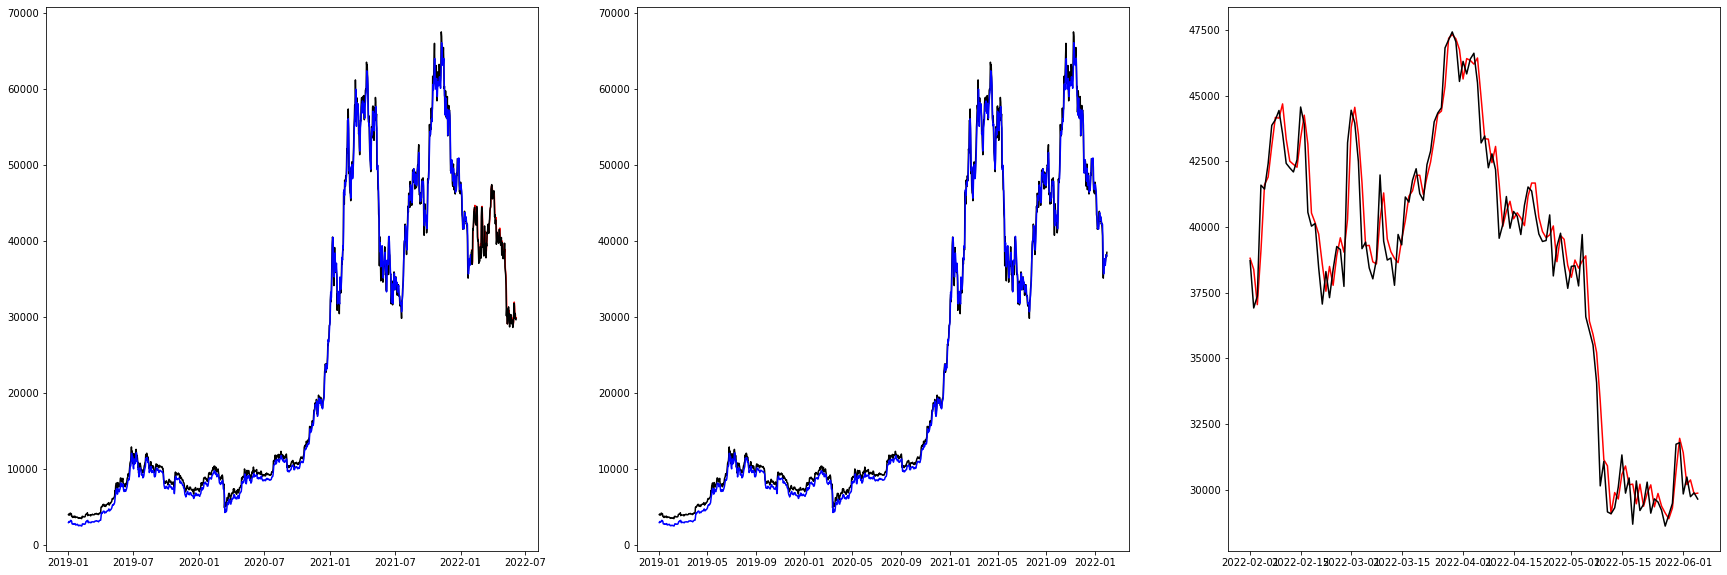

In [65]:
f,axs = plt.subplots(1,3,figsize=(30,10))

axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][:train_size], train_prediction, color='blue')
axs[0].plot(df['date'][train_size:], test_prediction, color='red')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='black')
axs[1].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[1].plot(df['date'][:train_size], train_prediction, color='blue')
axs[2].plot(df['date'][train_size:], test_prediction, color='red')
axs[2].plot(df['date'][train_size:], df['close'][train_size:], color='black')

plt.show()

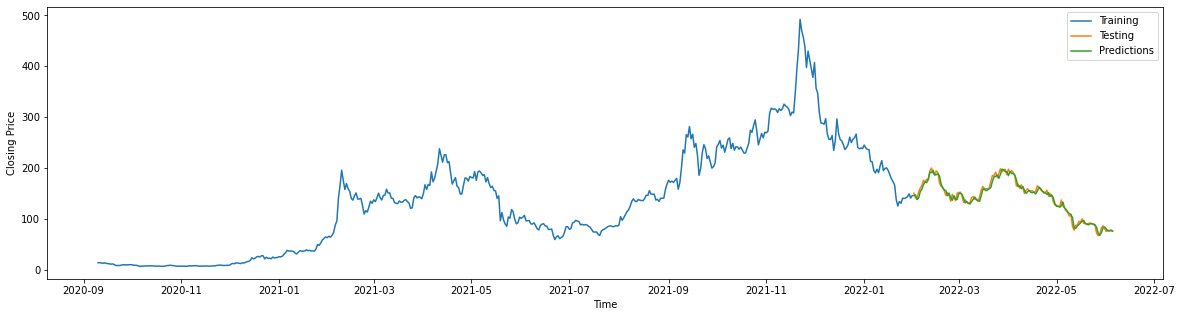

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(df['date'][df['date'] < date], y_train, label = 'Training')
plt.plot(df['date'][df['date'] >= date], y_test, label = 'Testing')
plt.plot(df['date'][df['date'] >= date], test_prediction, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

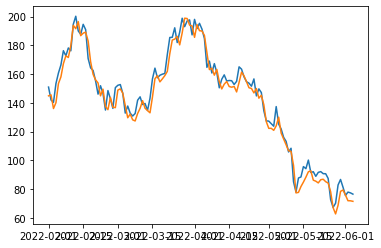

In [28]:
plt.plot(df['date'][df['date'] >= date], df['close'][df['date'] >= date], label = 'Testing')
plt.plot(df['date'][df['date'] >= date], test_prediction, label = 'Predictions')

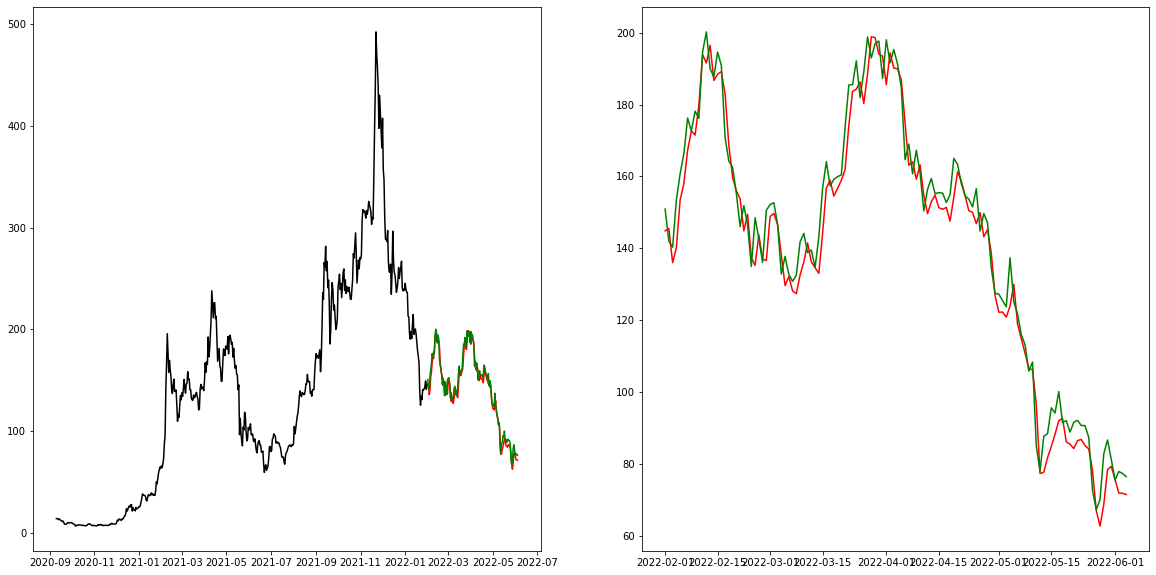

In [29]:
f,axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][train_size:], test_prediction, color='red')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[1].plot(df['date'][train_size:], test_prediction, color='red')
axs[1].plot(df['date'][train_size:], df['close'][train_size:], color='green')

### Tuning Test

In [46]:
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [47]:
date = '2022-02-01'
X_train, y_train, X_test, y_test = SplitData(df, date, lstm=1)

509


In [48]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(y_train.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [49]:
tuner = RandomSearch(
        build_model,
        objective='mse',
        max_trials=4,
        executions_per_trial=1,
        directory='my_dir1'
        )

In [50]:
tuner.search(
        x=X_train,
        y=y_train,
        epochs=50,
        batch_size=128,
        validation_data=(X_test,y_test),
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
32                |?                 |input_unit
3                 |?                 |n_layers
288               |?                 |lstm_0_units
256               |?                 |layer_2_neurons
0.1               |?                 |Dropout_rate
sigmoid           |?                 |dense_activation

Epoch 1/50
4/4 [==============================] - 13s 884ms/step - loss: 0.0971 - mse: 0.0971 - val_loss: 0.0458 - val_mse: 0.0458
Epoch 2/50
4/4 [==============================] - 0s 106ms/step - loss: 0.0867 - mse: 0.0867 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 3/50
4/4 [==============================] - 0s 127ms/step - loss: 0.0691 - mse: 0.0691 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 4/50
4/4 [==============================] - 0s 125ms/step - loss: 0.0497 - mse: 0.0497 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 5/50
4/4 [==============================] - 0s 125ms/step - loss: 0.0485 - mse: 0.048

NotFoundError: Failed to rename: my_dir1\untitled_project\trial_0\checkpoint_temp/part-00000-of-00001.data-00000-of-00001 to: my_dir1\untitled_project\trial_0\checkpoint.data-00000-of-00001 : The system cannot find the file specified.
; No such file or directory [Op:MergeV2Checkpoints]

In [35]:
best_lstm_model = tuner.get_best_models(num_models=1)[0]

In [36]:
# make predictions
train_prediction = best_lstm_model.predict(X_train)
test_prediction = best_lstm_model.predict(X_test)

# invert predictions

# create empty table with 4 fields
train_prediction_dataset_like, test_prediction_dataset_like = np.zeros(shape=(len(train_prediction), X_train.shape[1])), np.zeros(shape=(len(test_prediction), X_test.shape[1]))
# put the predicted values in the right field
train_prediction_dataset_like[:,0], test_prediction_dataset_like[:,0] = train_prediction[:,0], test_prediction[:,0]
# inverse transform and then select the right field
train_prediction, test_prediction = X_scaler.inverse_transform(train_prediction_dataset_like)[:,0], X_scaler.inverse_transform(test_prediction_dataset_like)[:,0]
train_prediction, test_prediction = train_prediction.reshape(-1,1), test_prediction.reshape(-1,1)

y_train = y_scaler.inverse_transform(y_train)
y_test = y_scaler.inverse_transform(y_test)

In [37]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_prediction)))
print("Train data MSE: ", mean_squared_error(y_train,train_prediction))
print("Train data MAE: ", mean_absolute_error(y_train,train_prediction))
print("Train data explained variance regression score:", explained_variance_score(y_train, train_prediction))
print("Train data R2 score:", r2_score(y_train, train_prediction))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_prediction)))
print("Test data MSE: ", mean_squared_error(y_test,test_prediction))
print("Test data MAE: ", mean_absolute_error(y_test,test_prediction))
print("Test data explained variance regression score:", explained_variance_score(y_test, test_prediction))
print("Test data R2 score:", r2_score(y_test, test_prediction))

Train data RMSE:  9.464303415598762
Train data MSE:  89.57303914251439
Train data MAE:  6.168125263202896
Train data explained variance regression score: 0.9914296575575695
Train data R2 score: 0.9913694407841434
-------------------------------------------------------------------------------------
Test data RMSE:  6.406438028680374
Test data MSE:  41.042448215322075
Test data MAE:  5.151102522677627
Test data explained variance regression score: 0.9681090477224017
Test data R2 score: 0.9679401656220356


## Try Forecasting

In [120]:
df = fetch_data(start=t_start, stop=t_stop, symbol=pair, interval=interval)
df

No keys, only access to public API functions


,date,open,close,high,low,volume
0,2020-09-10,22.000,14.310,22.000,9.888,16713.541178
1,2020-09-11,14.310,14.321,14.353,14.023,9028.975189
2,2020-09-12,14.324,13.924,14.325,13.803,3973.408883
3,2020-09-13,13.923,13.311,13.979,13.176,3926.393715
4,2020-09-14,13.317,13.981,14.323,13.136,16590.201933
...,...,...,...,...,...,...
628,2022-05-31,86.683,81.348,86.683,80.211,2604.434906
629,2022-06-01,81.490,75.585,85.666,75.277,5316.625200
630,2022-06-02,75.559,77.974,82.139,74.507,3724.146589
631,2022-06-03,77.788,77.432,79.100,75.429,2230.617673


In [29]:
y = df['close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [30]:
# fit the model
model = build_lstm_model(X, output_size=n_forecast, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=50, batch_size=32, verbose=0)



C:\Users\freez\AppData\Local\Temp\ipykernel_12236\4079605446.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['date'] = pd.to_datetime(df_past['date'])
C:\Users\freez\AppData\Local\Temp\ipykernel_12236\4079605446.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['Forecast'] = np.nan
C:\Users\freez\AppData\Local\Temp\ipykernel_12236\4079605446.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

<AxesSubplot:title={'center':'AAPL'}, xlabel='date'>

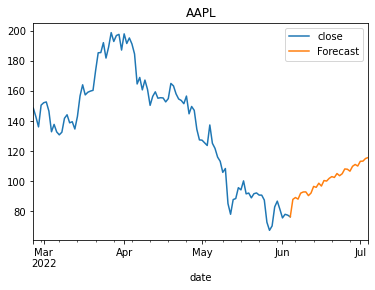

In [101]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['date', 'close']]
df_past['date'] = pd.to_datetime(df_past['date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['close'].iloc[-1]

df_future = pd.DataFrame(columns=['date', 'close', 'Forecast'])
df_future['date'] = pd.date_range(start=df_past['date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['close'] = np.nan

results = df_past[-100:].append(df_future).set_index('date')

# plot the results
results.plot(title='AAPL')

In [103]:
results

,close,Forecast
date,,
2022-02-25,148.53,NaN
2022-02-26,142.79,NaN
2022-02-27,136.14,NaN
2022-02-28,150.59,NaN
2022-03-01,152.20,NaN
...,...,...
2022-06-30,NaN,110.096100
2022-07-01,NaN,113.266235
2022-07-02,NaN,113.351585


In [104]:
df_past.iloc[-1]

date        2022-06-04 00:00:00
close                     76.31
Forecast                  76.31
Name: 632, dtype: object

In [105]:
new_row = pd.DataFrame({'date': df_past.iloc[-1]['date'], 'close': df_past.iloc[-1]['close'], 'Forecast': df_past.iloc[-1]['Forecast']}, index=[0])
new_row

,date,close,Forecast
0,2022-06-04,76.31,76.31


In [106]:
df_future = pd.concat([new_row, df_future], axis=0).reset_index(drop=True)


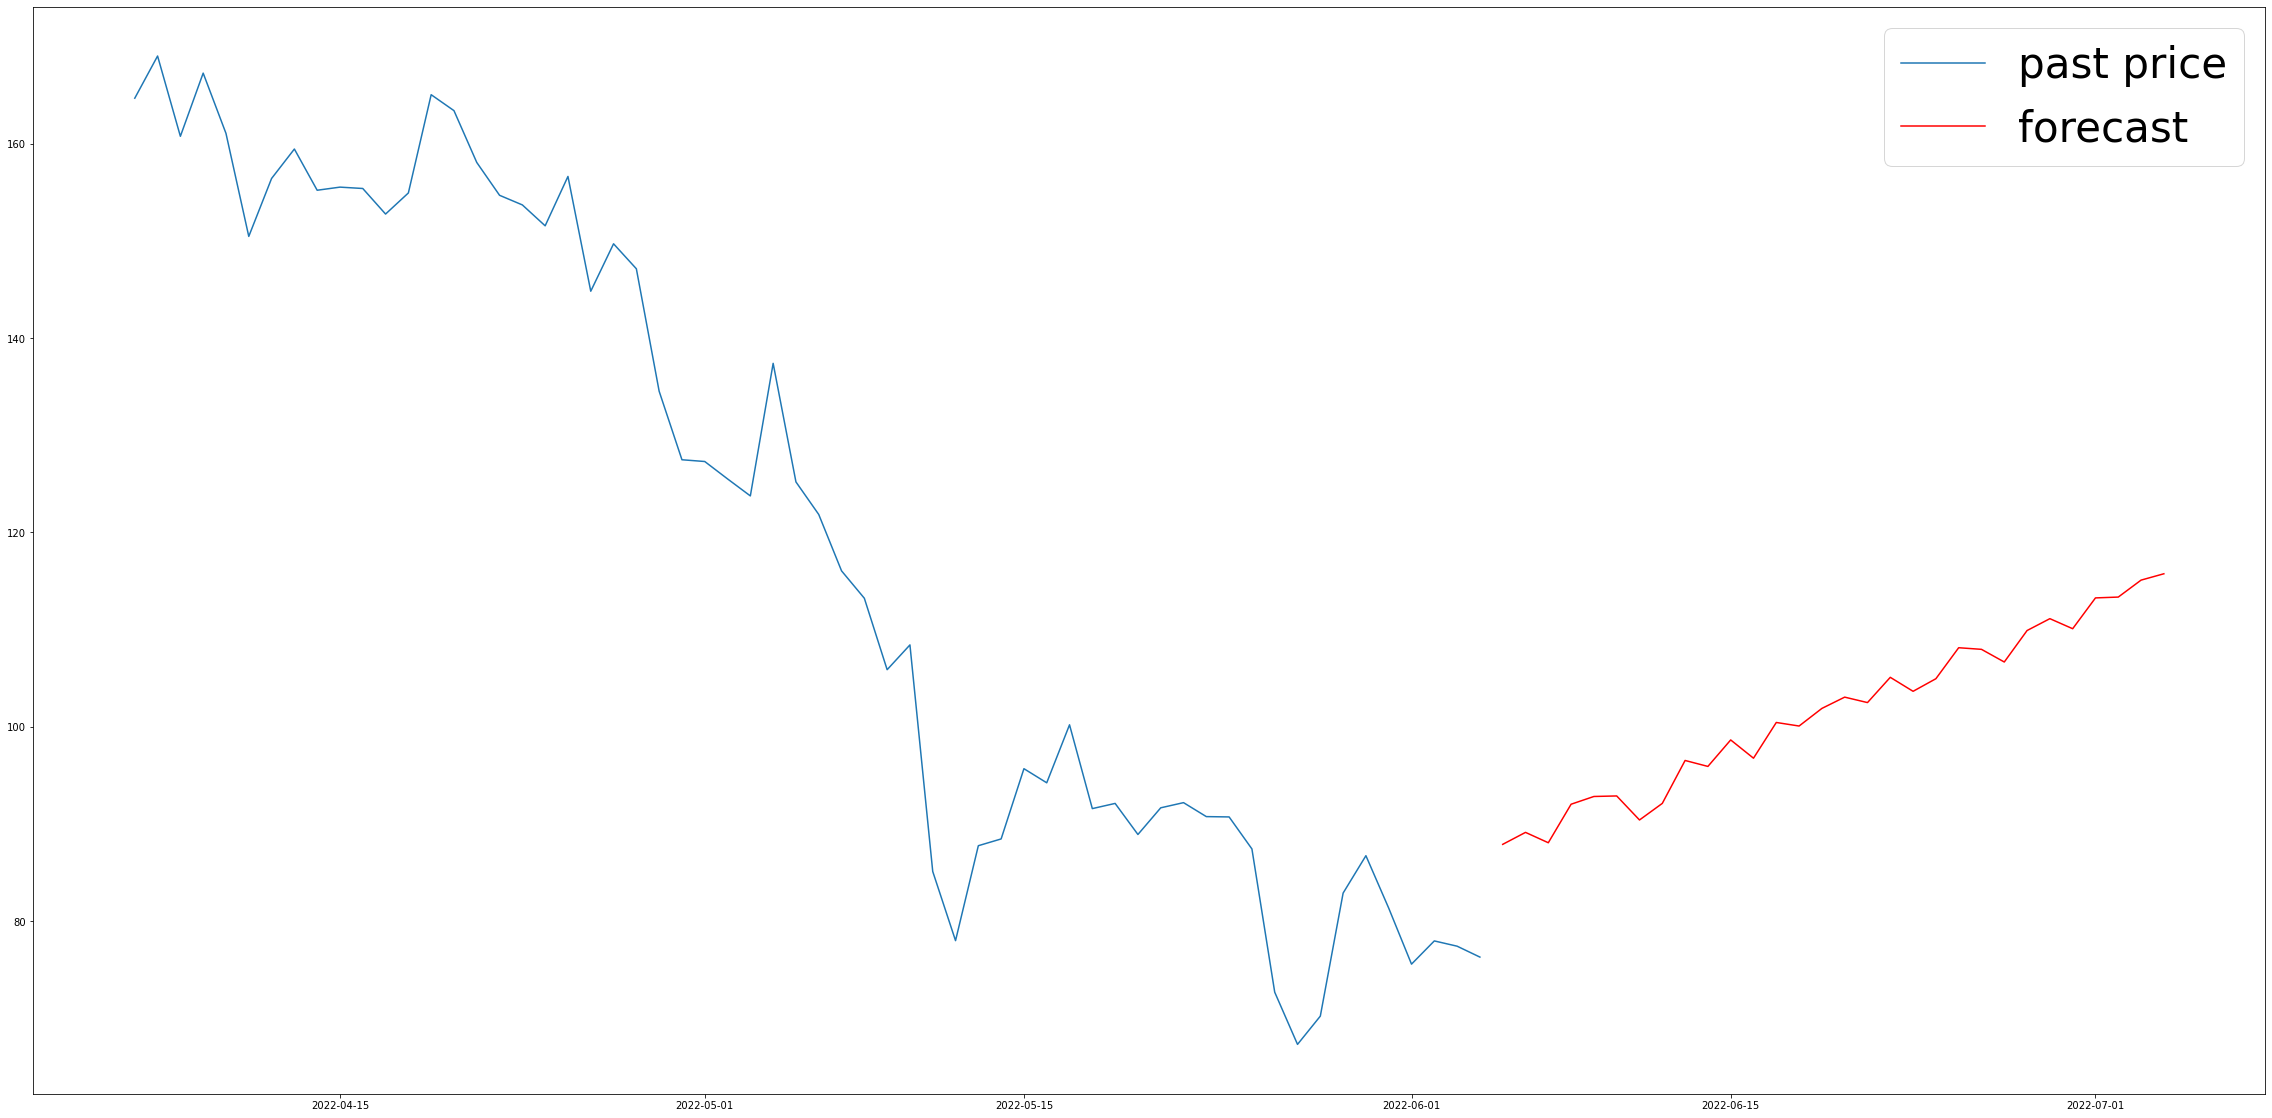

In [62]:
fig, ax = plt.subplots(figsize=(40,20))
ax.plot(df_past['date'][-n_lookback:], df_past['close'][-n_lookback:])
ax.plot(df_future['date'], df_future['Forecast'], color='red')
ax.legend(['past price', 'forecast'], prop={'size': 42})
plt.show()

In [66]:
def split_data(df, date):
    data = df.copy()
    data.reset_index(inplace=True)
    index = data.index[data['date'] == date][0]
    X = data.drop(columns=['index', 'date', 'close'], axis=1).to_numpy()
    y = data['close'].to_numpy()
    return X, y, index

In [67]:
X, y, index = split_data(df, '2021-01-12')



X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

X = X_scaler.fit_transform(np.array(X))
y = y_scaler.fit_transform(np.array(y).reshape(-1,1))

X_train = X[:index]
y_train = y[:index]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = X[index:]
y_test = y[index:]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


lstm_neurons = 100
epochs = 50
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'


lstm_model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
hist = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False)

# make predictions
lstm_train_prediction = lstm_model.predict(X_train)
lstm_test_prediction = lstm_model.predict(X_test)

# invert predictions
## create empty table with 4 fields
lstm_train_prediction_dataset_like, lstm_test_prediction_dataset_like = np.zeros(shape=(len(lstm_train_prediction), X_train.shape[1])), np.zeros(shape=(len(lstm_test_prediction), X_test.shape[1]))
## put the predicted values in the right field
lstm_train_prediction_dataset_like[:,0], lstm_test_prediction_dataset_like[:,0] = lstm_train_prediction[:,0], lstm_test_prediction[:,0]
## inverse transform and then select the right field
lstm_train_prediction, lstm_test_prediction = X_scaler.inverse_transform(lstm_train_prediction_dataset_like)[:,0], X_scaler.inverse_transform(lstm_test_prediction_dataset_like)[:,0]
lstm_train_prediction, lstm_test_prediction = lstm_train_prediction.reshape(-1,1), lstm_test_prediction.reshape(-1,1)

y_train = y_scaler.inverse_transform(y_train)
y_test = y_scaler.inverse_transform(y_test)

Epoch 1/50
24/24 [==============================] - 7s 78ms/step - loss: 0.0033 - val_loss: 0.1354
Epoch 2/50
24/24 [==============================] - 1s 21ms/step - loss: 0.0038 - val_loss: 0.0739
Epoch 3/50
24/24 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0146
Epoch 4/50
24/24 [==============================] - 0s 14ms/step - loss: 5.1600e-04 - val_loss: 6.7917e-04
Epoch 5/50
24/24 [==============================] - 0s 17ms/step - loss: 2.0694e-04 - val_loss: 7.9748e-04
Epoch 6/50
24/24 [==============================] - 0s 13ms/step - loss: 2.6806e-04 - val_loss: 0.0011
Epoch 7/50
24/24 [==============================] - 0s 14ms/step - loss: 2.4532e-04 - val_loss: 4.5429e-04
Epoch 8/50
24/24 [==============================] - 0s 10ms/step - loss: 3.2186e-04 - val_loss: 7.8776e-04
Epoch 9/50
24/24 [==============================] - 0s 11ms/step - loss: 1.9786e-04 - val_loss: 4.6446e-04
Epoch 10/50
24/24 [==============================] - 0s 8ms/step 

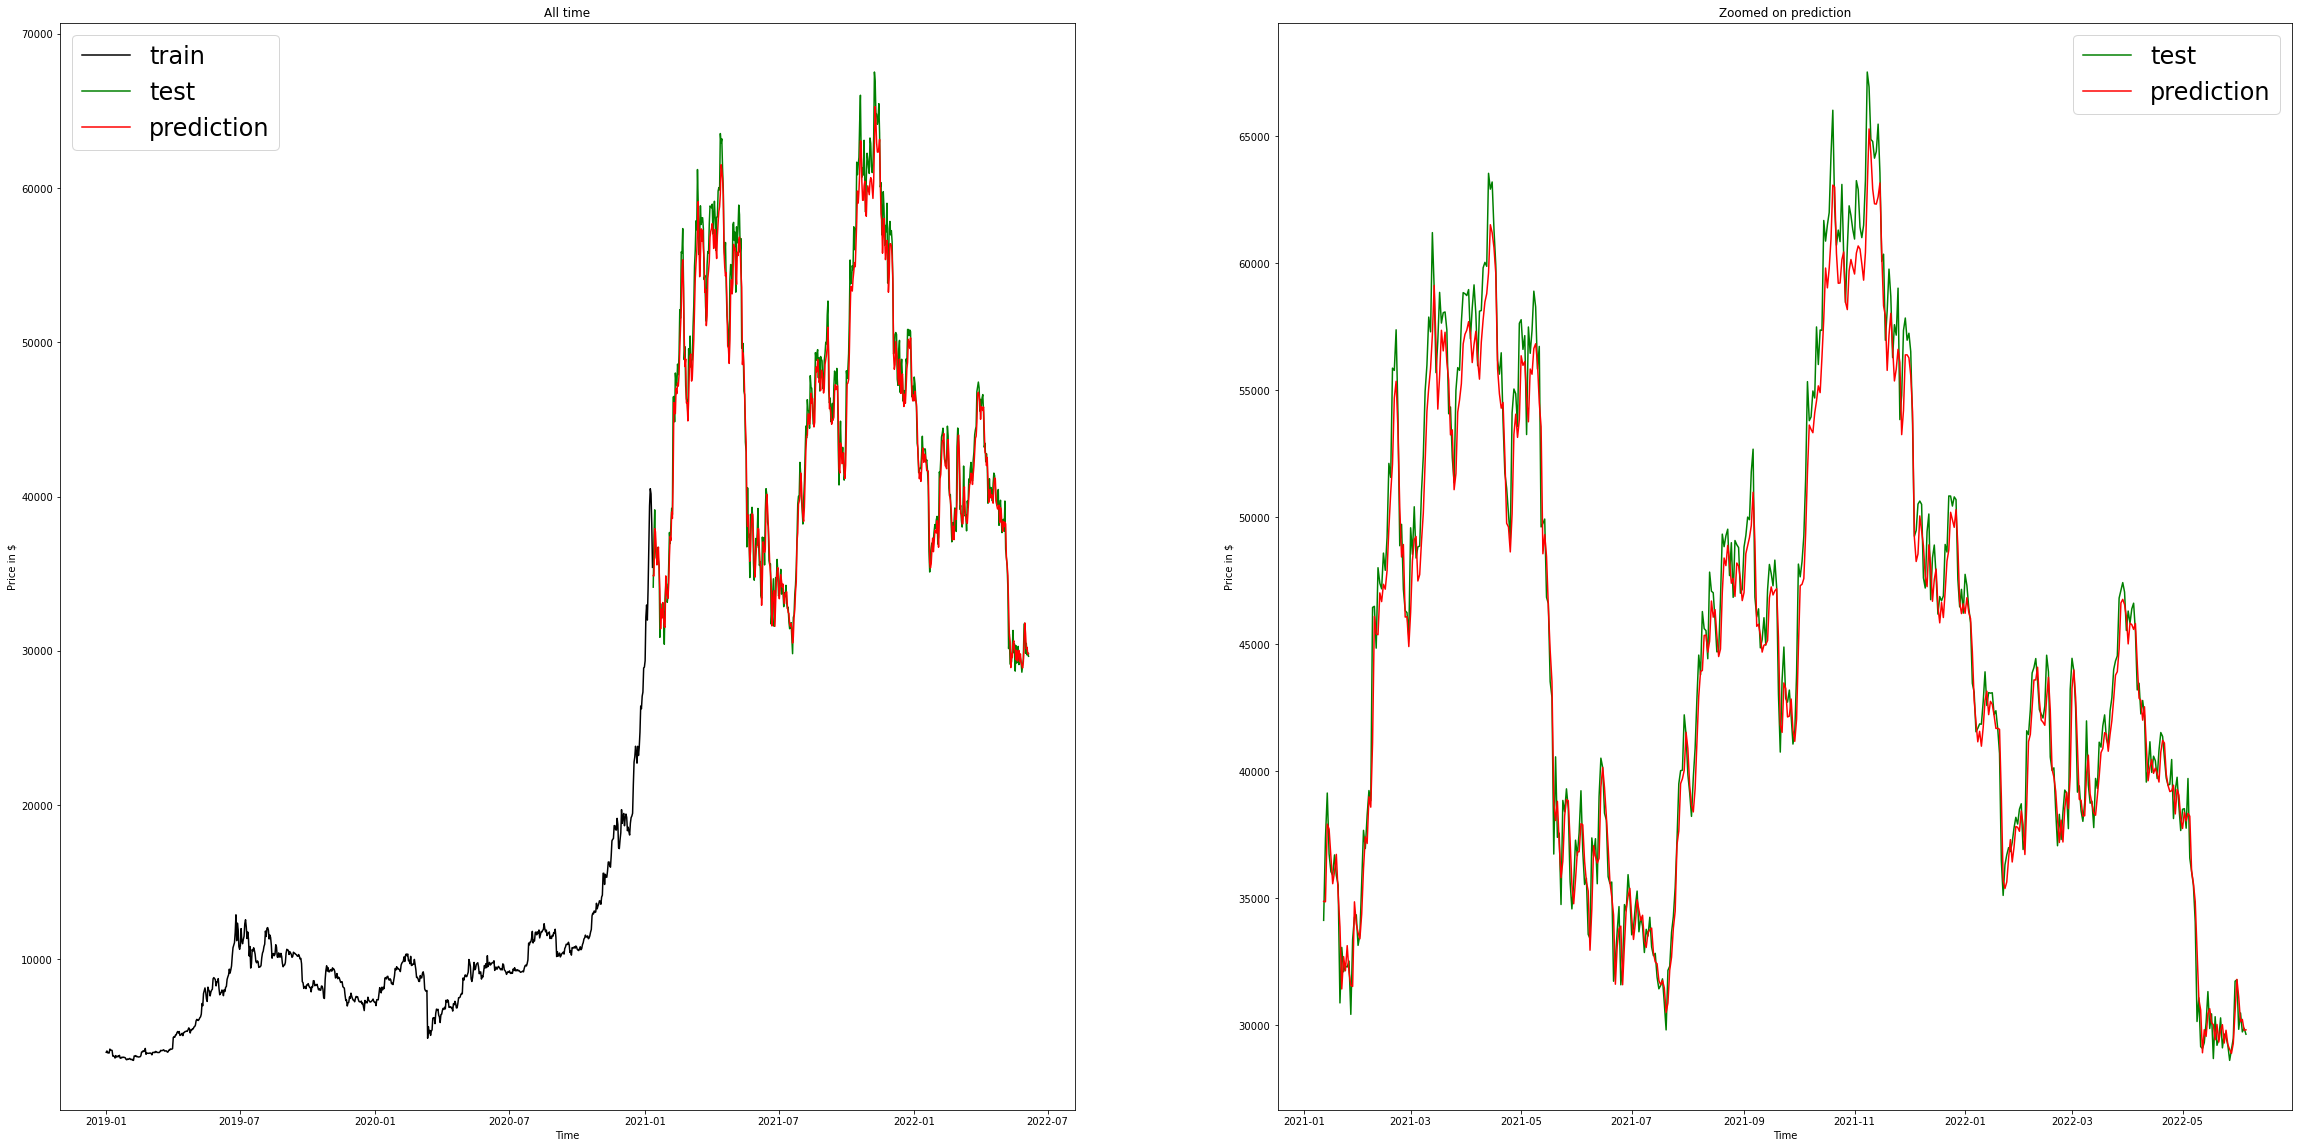

In [69]:
train_size = X_train.shape[0]
f,axs = plt.subplots(1,2,figsize=(40,20))

axs[0].set_title("All time")
axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[0].plot(df['date'][train_size:], lstm_test_prediction, color='red')
axs[0].legend(['train', 'test', 'prediction'], prop={'size': 24})

axs[1].set_title("Zoomed on prediction")
axs[1].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[1].plot(df['date'][train_size:], lstm_test_prediction, color='red')
axs[1].legend(['test', 'prediction'], prop={'size': 24})

for ax in axs.flat:
    ax.set(xlabel="Time", ylabel="Price in $")

plt.show()